### Importar base de dados e instalar framework de recomendação

### Importar bibliotecas

In [1]:
# import wget
!wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz

--2025-08-11 22:56:43--  https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mmanzato/MBABigData/master/ml-20m-compact.tar.gz [following]
--2025-08-11 22:56:43--  https://raw.githubusercontent.com/mmanzato/MBABigData/master/ml-20m-compact.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65019041 (62M) [application/octet-stream]
Saving to: ‘ml-20m-compact.tar.gz’

ml-20m-compact.tar. 100%[===================>]  62.01M   254MB/s    in 0.2s    

2025-08-11 22:56:44 (254 MB/s) - ‘ml-20m-compact.tar.gz’ saved [65019041/65019041

In [2]:
import sys
!{sys.executable} -m pip install caserecommender

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 2.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
np.asfarray = np.asarray

### Explorar Dados

In [4]:
movies = pd.read_csv('./dataset/movies_sample.csv')
movies.tail()

,movieId,title,genres
428,129857,Bright Days Ahead (2013),Drama|Romance
429,130344,Coast of Death (2013),Children|Documentary|Drama
430,130408,A Rumor Of War (1980),(no genres listed)
431,130510,Berserk: The Golden Age Arc 3 - Descent (2013),Action|Animation|Fantasy
432,131239,Three Quarter Moon (2011),Comedy|Drama


In [5]:
ratings = pd.read_csv('./dataset/ratings_sample.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,11,7481,5.0,1230788624
1,11,1046,4.5,1251144145
2,11,616,4.0,1230782542
3,11,3535,2.0,1230784884
4,11,5669,5.0,1230853788


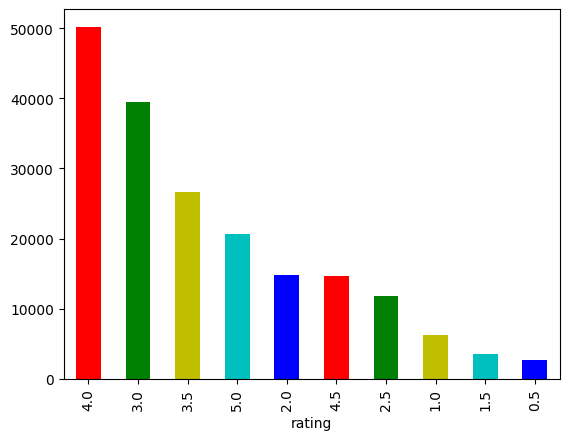

In [6]:
import matplotlib.pyplot as plt
ratings.rating.value_counts().plot(kind='bar', color=['r', 'g', 'y', 'c', 'b']);
plt.show()

In [7]:
df = ratings[['userId', 'movieId', 'rating']]
df.tail()

,userId,movieId,rating
190616,138493,288,5.0
190617,138493,1748,5.0
190618,138493,616,4.0
190619,138493,1597,4.5
190620,138493,7371,5.0


In [8]:
df = df.merge(movies[['movieId', 'title']])
df.head()

,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,11,1046,4.5,Beautiful Thing (1996)
2,11,616,4.0,"Aristocats, The (1970)"
3,11,3535,2.0,American Psycho (2000)
4,11,5669,5.0,Bowling for Columbine (2002)


### Números de usuários e número de itens

In [9]:
print(
"""
Número de usuários: {}
Número de itens: {}
Número de interações: {}
""".format(
    df.userId.nunique(),
    df.movieId.nunique(),
    df.shape[0]
)
)


Número de usuários: 11090
Número de itens: 417
Número de interações: 190621



### Mapeamento em idx

In [10]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}

In [11]:
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)
df.head()

,userId,movieId,rating,title
0,0,0,5.0,Enemy Mine (1985)
1,0,1,4.5,Beautiful Thing (1996)
2,0,2,4.0,"Aristocats, The (1970)"
3,0,3,2.0,American Psycho (2000)
4,0,4,5.0,Bowling for Columbine (2002)


In [12]:
map_title = {}

for _, row in df.iterrows():
    map_title[row.movieId] = row.title

In [13]:
print(len(map_title))
print(map_title[100])

417
Send Me No Flowers (1964)


In [14]:
# qtd interações dos usuários
df.groupby('userId').count()

,movieId,rating,title
userId,,,
0,13,13,13
1,14,14,14
2,15,15,15
3,15,15,15
4,11,11,11
...,...,...,...
11085,16,16,16
11086,11,11,11
11087,13,13,13


### Divisão do dataset

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)
train.to_csv('train.txt', index=False, header=False, sep='\t')
test.to_csv('test.txt', index=False, header=False, sep='\t')

In [16]:
! ls -l

total 70792
drwxr-xr-x 2  501 staff     4096 Mar 17  2022 dataset
-rw-r--r-- 1 root root  65019041 Aug 11 22:56 ml-20m-compact.tar.gz
drwxr-xr-x 1 root root      4096 Aug  8 20:22 sample_data
-rw-r--r-- 1 root root   1491068 Aug 11 22:57 test.txt
-rw-r--r-- 1 root root   5966209 Aug 11 22:57 train.txt


In [17]:
print('No. items: ' + str(train['movieId'].nunique()))
print('No. users: ' + str(train['userId'].nunique()))

No. items: 405
No. users: 11090


### Recomendadores

## Prever notas

In [18]:
from caserec.recommenders.rating_prediction.most_popular import MostPopular

In [19]:
MostPopular('train.txt', 'test.txt', 'out_mp_pred.txt').compute()

[Case Recommender: Rating Prediction > Most Popular]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

prediction_time:: 73.007831 sec


Eval:: MAE: 0.701356 RMSE: 0.908405 


In [20]:
df_pred = pd.read_csv('out_mp_pred.txt', sep='\t', names=['userId', 'movieId', 'pred'])
df_pred.head(10)

,userId,movieId,pred
0,0,5,3.340482
1,0,0,3.462625
2,1,13,3.501614
3,1,16,3.075567
4,1,14,3.654597
5,1,19,4.070841
6,1,24,2.841837
7,1,20,3.174392
8,2,21,3.209831
9,3,33,4.192866


In [21]:
test[test.userId == 1]

,userId,movieId,rating,title
13,1,13,5.0,Sliding Doors (1998)
16,1,16,4.0,Rush Hour 2 (2001)
14,1,14,4.0,Go (1999)
21,1,19,5.0,Reservoir Dogs (1992)
26,1,24,3.0,"Deep End of the Ocean, The (1999)"
22,1,20,3.0,While You Were Sleeping (1995)


In [22]:
df_pred = df_pred.merge(test)

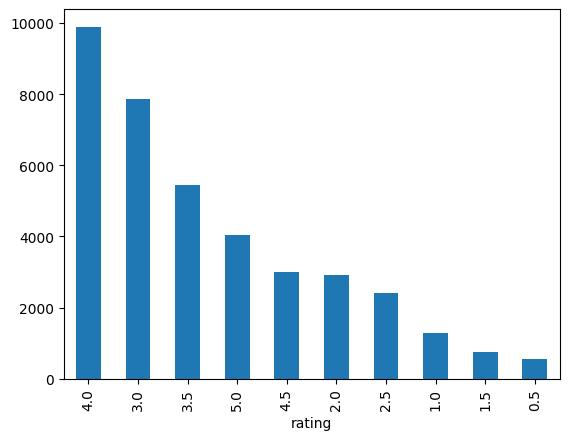

In [23]:
df_pred.rating.value_counts().plot(kind='bar')
plt.show()

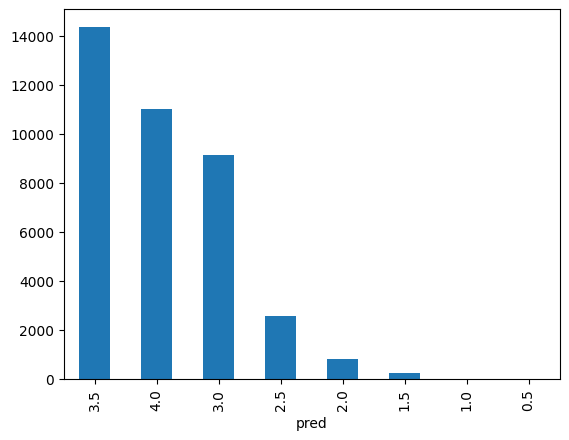

In [24]:
df_pred['pred'] = round(df_pred['pred']*2)/2
df_pred.pred.value_counts().plot(kind='bar');
plt.show()

### Top N

In [25]:
from caserec.recommenders.item_recommendation.most_popular import MostPopular as MPR

In [26]:
MPR('train.txt', 'test.txt', 'out_mp_pred_binary.txt', as_binary=True).compute()

[Case Recommender: Item Recommendation > Most Popular]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

prediction_time:: 2.273828 sec


Eval:: PREC@1: 0.38407 PREC@3: 0.251159 PREC@5: 0.210936 PREC@10: 0.164895 RECALL@1: 0.124528 RECALL@3: 0.229538 RECALL@5: 0.314706 RECALL@10: 0.481962 MAP@1: 0.38407 MAP@3: 0.454719 MAP@5: 0.46042 MAP@10: 0.437819 NDCG@1: 0.38407 NDCG@3: 0.523129 NDCG@5: 0.547547 NDCG@10: 0.554529 


In [27]:
ranking = pd.read_csv('out_mp_pred_binary.txt', sep='\t', names=['userId', 'movieId', 'score'])
ranking['title'] = ranking.movieId.map(map_title)
ranking.head(15)

,userId,movieId,score,title
0,0,19,6444.0,Reservoir Dogs (1992)
1,0,22,4535.0,Natural Born Killers (1994)
2,0,17,4484.0,Chasing Amy (1997)
3,0,18,4356.0,Life Is Beautiful (La Vita è bella) (1997)
4,0,33,3855.0,North by Northwest (1959)
5,0,5,3567.0,"I, Robot (2004)"
6,0,21,3560.0,Conspiracy Theory (1997)
7,0,20,3495.0,While You Were Sleeping (1995)
8,0,23,3482.0,Crimson Tide (1995)
9,0,28,3392.0,My Best Friend's Wedding (1997)


### Item KNN

In [28]:
from caserec.recommenders.rating_prediction.itemknn import ItemKNN

ItemKNN('train.txt', 'test.txt', 'rp_iknn.txt', as_similar_first=True).compute()

[Case Recommender: Rating Prediction > ItemKNN Algorithm]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

training_time:: 4.438790 sec
prediction_time:: 0.614964 sec
Eval:: MAE: 0.663504 RMSE: 0.872175 


**Exercício 01:**

a) Encontrar o id do usuário que avaliou mais filmes na base. Informe o id externo (da base dados) e o interno (usado pelo recomendador)

In [29]:
# Agrupamento da qtd de avaliaçõs de cada usuário
user_counts = ratings['userId'].value_counts()

# IDs externos e internos
external_id = user_counts.index[0]
internal_id = map_users[external_id]

print(f"* ID externo: {external_id} | ID Interno: {internal_id}")
print(f"O usuário que mais avaliou filmes tem: {user_counts.iloc[0]} avaliações.")

* ID externo: 118205 | ID Interno: 9518
O usuário que mais avaliou filmes tem: 163 avaliações.


b) Encontrar os 5 primeiros usuários que têm maior propensão a dar notas baixas aos filmes (use a média de ratings para isso).

In [30]:
# Média de avaliações
mean_ratings = ratings.groupby('userId')['rating'].mean()

# 5 com menores médias de avaliações
top_5_lowest_raters = mean_ratings.sort_values(ascending=True).head(5)

print("Os 5 usuários com as menores médias de avaliação são:")
print(top_5_lowest_raters)

Os 5 usuários com as menores médias de avaliação são:
userId
113857    0.735294
2084      0.961538
83891     1.115385
102570    1.205882
135142    1.307692
Name: rating, dtype: float64


c) Encontrar os 5 filmes pior avaliados pelos usuários.

In [31]:
# Agrupamento dos filmes com as avaliações
merged_df = pd.merge(ratings, movies, on='movieId')

# Média de avaliações e 5 piores
mean_ratings_movie = merged_df.groupby('title')['rating'].mean()
top_5_worst_movies = mean_ratings_movie.sort_values(ascending=True).head(5)

print("Os 5 filmes com as piores valiações:")
print(top_5_worst_movies)

Os 5 filmes com as piores valiações:
title
Hercules (2005)                             1.000000
Heroic Purgatory (Rengoku eroica) (1970)    1.000000
Snapshot (1979)                             1.000000
Loaded (2008)                               1.166667
Last Chance (2014)                          1.500000
Name: rating, dtype: float64


**Exercício 02:** Na aula vimos uma abordagem de recomendação não personalizada que utiliza a quantidade de interações dos itens para recomendar filmes mais populares aos usuários. Quando há feedback explícito, entretanto, a mesma abordagem "Most Popular" pode fazer uso da média das notas disponíveis, ou seja, recomendam-se os N filmes mais bem avaliados a cada usuário. Desse modo, calcule a recomendação de 5 filmes para um usuário qualquer da base considerando essa estratégia não personalizada. Utilize a base toda como conjunto de treinamento.

In [32]:
# Agrupamento dos filmes com as avaliações
df_merged = pd.merge(ratings, movies, on='movieId')

movie_stats = df_merged.groupby('title')['rating'].agg(['mean', 'count'])

# Filmes mais populares com pelo menos 10 avaliações
min_ratings = 10
popular_movies = movie_stats[movie_stats['count'] >= min_ratings]

# Orderna e pega os 5 mais pop
top_5 = popular_movies.sort_values(by='mean', ascending=False).head(5)

print("Top 5 filmes recomendados (não personalizados) com maior nota média:")
print(top_5)

Top 5 filmes recomendados (não personalizados) com maior nota média:
                                                        mean  count
title                                                              
North by Northwest (1959)                           4.199626   4809
Star Wars: Episode V - The Empire Strikes Back ...  4.178017   9530
Napoléon (1927)                                     4.107143     14
Samouraï, Le (Godson, The) (1967)                   4.066667    375
Reservoir Dogs (1992)                               4.061329   8006


**Exercício 03:** Com base no código disponível no notebook "Aula01_Exemplos.ipynb", implemente uma função que retorna os k filmes mais similares a um outro qualquer passado como parâmetro.

In [35]:
from math import sqrt, pow

if not ratings.empty:

    # Agrupar
    df = ratings[['userId', 'movieId', 'rating']]
    df = df.merge(movies[['movieId', 'title']])

    # MApear os IDs
    map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
    map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}

    df['user_idx'] = df['userId'].map(map_users)
    df['item_idx'] = df['movieId'].map(map_items)

    map_idx_to_title = pd.Series(df.title.values, index=df.item_idx).to_dict()

# Usuarios que avaliaram um item
def get_users_who_rated_item(item_idx):

    if item_idx not in df['item_idx'].values:
        return []
    return df.loc[df.item_idx == item_idx, 'user_idx'].tolist()

# Avaliação do usuário no item
def get_rating(user_idx, item_idx):

    rating_entry = df[(df['user_idx'] == user_idx) & (df['item_idx'] == item_idx)]
    if rating_entry.empty:
        return 0
    return rating_entry['rating'].iloc[0]

# média de notas o user
def get_user_mean(user_idx):

    ratings_list = df.loc[df.user_idx == user_idx, 'rating'].tolist()
    return np.mean(ratings_list) if ratings_list else 0

# Similaridade entre dois itens (com Similaridade de Cosseno Ajustada)
def item_similarity_score(item_idx1, item_idx2):

    common_users = list(set(get_users_who_rated_item(item_idx1)) & set(get_users_who_rated_item(item_idx2)))

    # Pelo menos 2 usuários para calculo
    if len(common_users) < 2:
        return 0

    numerator = 0
    denominator_part1 = 0
    denominator_part2 = 0

    # Calculos gerais para similaridade
    for user_idx in common_users:
        user_mean = get_user_mean(user_idx)
        rating1 = get_rating(user_idx, item_idx1)
        rating2 = get_rating(user_idx, item_idx2)

        adj_rating1 = rating1 - user_mean
        adj_rating2 = rating2 - user_mean

        numerator += adj_rating1 * adj_rating2
        denominator_part1 += pow(adj_rating1, 2)
        denominator_part2 += pow(adj_rating2, 2)

    if denominator_part1 == 0 or denominator_part2 == 0:
        return 0

    return numerator / (sqrt(denominator_part1) * sqrt(denominator_part2))

# Pegar os K filmes mais similares
def get_k_similar_items(target_movie_title, k=5):

    # Mapa de titulo -> ID
    map_title_to_idx = {v: k for k, v in map_idx_to_title.items()}

    if target_movie_title not in map_title_to_idx:
        print(f"* Erro: Filme '{target_movie_title}' não encontrado.")
        return

    target_item_idx = map_title_to_idx[target_movie_title]
    item_indices = df.item_idx.unique().tolist()

    print(f"Calculando similaridades para '{target_movie_title}'...")

    # Para cada item (filme) calcular a similaridade com o filme alvo
    sim = [(item_similarity_score(target_item_idx, other_item_idx), other_item_idx)
           for other_item_idx in item_indices if other_item_idx != target_item_idx]

    sim.sort(key=lambda x: x[0], reverse=True)

    print(f"Os {k} filmes mais similares a '{target_movie_title}' são:\n")

    for similarity, item_idx in sim[:k]:
        print(f"- {map_idx_to_title[item_idx]} (Similaridade: {similarity:.4f})")


star_wars_movies = movies[movies['title'].str.contains("Star Wars", case=False, na=False)]
# print(star_wars_movies)

if not ratings.empty:
    get_k_similar_items(star_wars_movies.iloc[0]['title'], k=5)

Calculando similaridades para 'Star Wars: Episode V - The Empire Strikes Back (1980)'...
Os 5 filmes mais similares a 'Star Wars: Episode V - The Empire Strikes Back (1980)' são:

- Booker's Place: A Mississippi Story (2012) (Similaridade: 0.9988)
- The Last Gladiators (2011) (Similaridade: 0.9934)
- Tour De Force (Hin und weg) (2014) (Similaridade: 0.9866)
- Kid Galahad (1937) (Similaridade: 0.9540)
- Happiness Never Comes Alone (Un bonheur n'arrive jamais seul) (2012) (Similaridade: 0.9072)
